In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model


from matplotlib.animation import FuncAnimation

/home/roberta/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/roberta/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/roberta/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/roberta/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:5

In [2]:
model10 = load_model("FinchModel10c.hd5")
model10.load_weights('FinchModel10c.h5')
cddf = pd.read_csv("FinchModel10.csv")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [3]:
import sounddevice as sd
import queue

chunk_length = 350 * 64 + 1024
pre_trigger = 110
chunk = np.zeros((chunk_length,1),dtype='float32')
chunk[30:40,0] = 10.0
recorded_length = 0;

triggered = False
captured = False

q = queue.Queue()




def callback(indata, frames, time, status):
    global triggered
    if status:
        print(status)
    q.put(indata[::1, [0]])    
    if ~triggered:    
        maxi = indata.max()
        if maxi>.58:
            triggered = True

def catch_sound():
    global chunk,recorded_length,triggered
    
    max_hits = 3
    stride = int(64 * 48000/44100) 
    
    plt.ion()
    fig = plt.figure(figsize=(20,20))
    graph1 = fig.add_subplot(211)
    #graph2 = f.add_subplot(212,sharex=graph1)
    
    f, t, Sxx = signal.spectrogram(chunk[:,0], 44100.,nperseg = 512,noverlap = 512 - stride)
    St = np.transpose(Sxx[20:170,0:230])
    lsx = np.log10((1+10000.*St)/np.max(St))
    spim = graph1.matshow(np.transpose(lsx),origin='lower')
    plt.show()
    


    recorded_length = 0
    triggered = False
    instream =  sd.InputStream(channels=1, callback=callback, blocksize=1024,dtype='float32')     
    with instream:
        while True:
            item = q.get()
            if item is None:
                continue
            ilen = len(item)
            chunk = np.roll(chunk, -ilen, axis=0)
            chunk[-ilen:] = item
            if triggered:
                recorded_length +=ilen
            if recorded_length > chunk_length-pre_trigger:
                triggered = False
                graph1.clear()
                f, t, Sxx = signal.spectrogram(chunk[:,0], 44100.,nperseg = 512,noverlap = 512 - stride)
                St = np.transpose(Sxx[20:170,0:230])
                lsx = np.log10((1+10000.*St)/np.max(St))


                #graph1.matshow(np.transpose(lsx),origin='lower')
                spim.set_data(np.transpose(lsx))
                fig.canvas.draw()
                fig.canvas.flush_events()
                
                imlru = np.reshape(lsx,(1,230,150,1))

                p1 =  model10.predict(imlru/np.max(imlru))
                #plt.figure(1)
                #plt.figure(clear=True)
                #graph1.plot(p1[0,:])
                recorded_length = 0
                max_hits -=1
                if max_hits < 0:
                    break
            q.task_done()

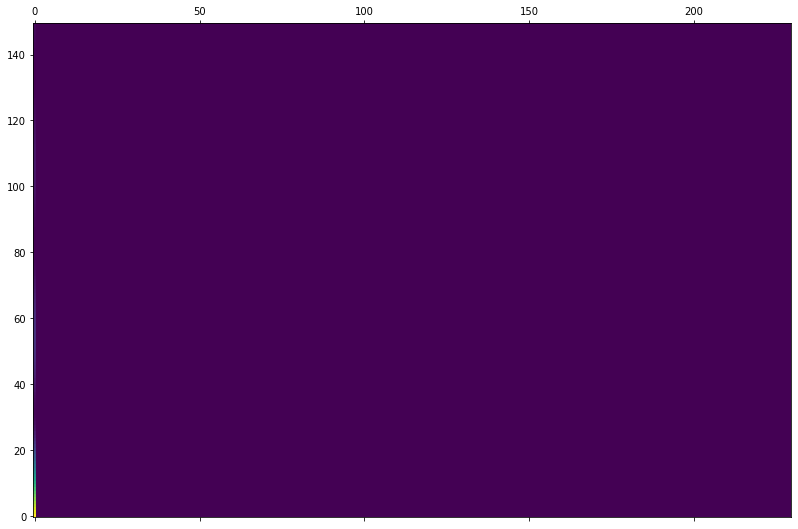

more ?


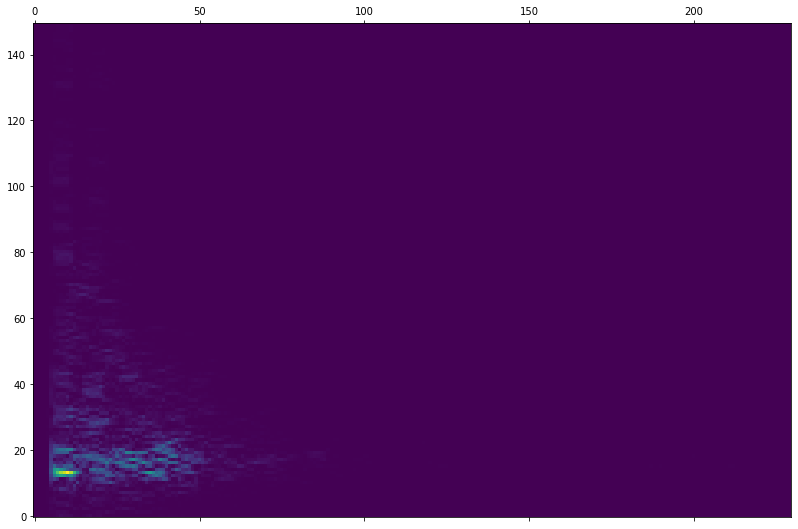

In [4]:
catch_sound()
print('more ?')